<a href="https://colab.research.google.com/github/jedkk/Machine-Learning/blob/main/predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict healthcare costs using a regression algorithm, given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

     |████████████████████████████████| 1.0MB 34.6MB/s 


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-05-27 11:56:16--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2021-05-27 11:56:16 (54.1 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [ ]:
for var in ['sex', 'smoker', 'region']:
  print(dataset[var].describe())

count     1338
unique       2
top       male
freq       676
Name: sex, dtype: object
count     1338
unique       2
top         no
freq      1064
Name: smoker, dtype: object
count          1338
unique            4
top       southeast
freq            364
Name: region, dtype: object


In [ ]:
dataset['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [ ]:
dataset['sex'] = dataset['sex'].astype('category')
dataset['sex'] = dataset['sex'].cat.codes
dataset['smoker'] = dataset['smoker'].astype('category')
dataset['smoker'] = dataset['smoker'].cat.codes
# or by np.where
#dataset['sex'] = np.where(dataset['sex'] == 'female', 1, 0)
#dataset['smoker'] = np.where(dataset['smoker'] == 'yes', 1, 0)
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,1,31.0,3,0,northwest,10600.55
1334,18,0,31.9,0,0,northeast,2205.98
1335,18,0,36.9,0,0,southeast,1629.83
1336,21,0,25.8,0,0,southwest,2007.95
1337,61,0,29.1,0,1,northwest,29141.36


In [ ]:
dataset['region'] = dataset['region'].astype('category')
dataset['region'] = dataset['region'].cat.codes
# or by using dummy variables
#dataset['region'] = dataset['region'].map({'northeast': 'northeast', 'northwest': 'northwest', 'southwest': 'southwest', 'southeast': 'southeast'})
#dataset = pd.get_dummies(dataset, columns=['region'], prefix='', prefix_sep='')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,1,31.0,3,0,1,10600.55
1334,18,0,31.9,0,0,0,2205.98
1335,18,0,36.9,0,0,2,1629.83
1336,21,0,25.8,0,0,3,2007.95
1337,61,0,29.1,0,1,1,29141.36


In [ ]:
# required split = 80/20
train_dataset = dataset.sample(frac=0.8, random_state=0) # features
test_dataset = dataset.drop(train_dataset.index)
train_labels, test_labels = train_dataset.pop('expenses'), test_dataset.pop('expenses') # labels

In [ ]:
test_dataset.head()

,age,sex,bmi,children,smoker,region
11,62,0,26.3,0,1,2
23,34,0,31.9,1,1,0
24,37,1,28.0,2,0,1
25,59,0,27.7,3,0,2
28,23,1,17.4,1,0,1


In [ ]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_dataset))

In [ ]:
model = keras.Sequential()
model.add(normalizer)
model.add(layers.Dense(64, input_dim=9, kernel_initializer='normal', activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 6)                 13        
_________________________________________________________________
dense_72 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_73 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [ ]:
model.compile(loss='mean_absolute_error', optimizer=tf.optimizers.Adam(learning_rate=0.1), metrics=['mae','mse'])
history = model.fit(train_dataset, train_labels, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
27/27 [==============================] - 1s 9ms/step - loss: 9307.5039 - mae: 9307.5039 - mse: 202844448.0000 - val_loss: 4576.7026 - val_mae: 4576.7026 - val_mse: 71687016.0000
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 3482.4097 - mae: 3482.4097 - mse: 42197456.0000 - val_loss: 3513.5793 - val_mae: 3513.5793 - val_mse: 35494892.0000
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 3104.3708 - mae: 3104.3708 - mse: 33462228.0000 - val_loss: 3073.5693 - val_mae: 3073.5693 - val_mse: 34786216.0000
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 2792.7117 - mae: 2792.7117 - mse: 29722604.0000 - val_loss: 3108.6218 - val_mae: 3108.6218 - val_mse: 30751772.0000
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 2515.0085 - mae: 2515.0085 - mse: 25221656.0000 - val_loss: 2662.1519 - val_mae: 2662.1519 - val_mse: 26482296.0000
Epoch 6/100
27/27 [==============================] - 0

9/9 - 0s - loss: 2219.9973 - mae: 2219.9973 - mse: 32104640.0000
Testing set Mean Abs Error: 2220.00 expenses
You passed the challenge. Great job!


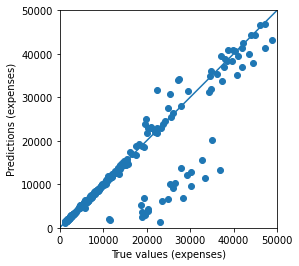

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
